# Convert audio files into spectrogram videos

Based on:   
https://github.com/fabincarmo/vidwav  
by fabincarmo@gmail.com  

TODO: on the upper plot draw a spectrum of current frame 

In [5]:

from pathlib import Path
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
        
import os

import librosa
import librosa.display

import pandas as pd
pow2 = pd.DataFrame([2**i for i in range(15)], list(range(15))).transpose()
pow2

import glob
from PIL import Image

import matplotlib.animation as manimation
import wave

from matplotlib.ticker import FuncFormatter

%matplotlib inline




## Preprocessing: convert audio formats
In case your files are not in wav format, use this short command.  
However you probably dont need this, as librosa supports a wide variety of formats

```
ffmpeg -loglevel error -i Media/lpf.mp3 Media/lpf.wav
```

## Functions

In [217]:

def wav2mp4(wavfile, spec_params = {}, scale = "linear", 
            figsize=(9.60,7.20), fps=25, cmap = 'magma', save = True ) :   
    """    
    spec_params: spectral parameters; 
                 dict with these keys: {'n_fft': 1024, 
                                        'hop_length': 128, 
                                        'n_mels': 256}
    scale: mel, linear, log
    figsize: figure size, inches, default:  (9.60,7.20)
    cmap: colormap to use for spectrogram, default 'magma'
    fps: desired video fps, default 25
    save: whether to actually save a video file. 
    since it takes some time to save, you might 
    want to preview the image first. 
    A .png image is saved anyway.
    """

    audio, fs = librosa.load(wavfile)
    # trim silent edges
    audio, _ = librosa.effects.trim(audio)
          
    
    # 1920, 1080
    #(19.20, 10.80)
    #(9.60,7.20)
    #(6.4, 4.8)
    fig = plt.figure(figsize=(9.60,7.20))#)
    
    sig = fig.add_subplot(16,1,(1,2))
    sig.margins(x=0)

    librosa.display.waveshow(audio, sr=fs, axis='time',ax=sig);
    sig.set_xlabel('')

    
    l1, = sig.plot([], [], '#333333', lw=2)
    
    spec = fig.add_subplot(16,1,(3,16))

    if spec_params == {}: #default
        spec_params = {'n_fft': 1024, 'hop_length': 128, 'n_mels': 256}

    print("drawing spectrogram with params:", spec_params)
    
    if scale=='mel':
        S = librosa.feature.melspectrogram(y=audio, **spec_params) 
        DB = librosa.power_to_db(S, ref=np.max)

    else:
        spec_params.pop('n_mels', None) # not relevant for regular spectrograms
        D = np.abs(librosa.stft(y=audio, **spec_params)) 
        DB = librosa.amplitude_to_db(D, ref=np.max)
    
    librosa.display.specshow(DB, sr= fs, hop_length=spec_params['hop_length'], 
                             x_axis='time', y_axis=scale, ax = spec, cmap = cmap);
    
    #plt.colorbar((format='%+2.0f dB');
    
    

    spec.set_xlabel('Time (sec)')
    spec.set_ylabel(f'Frequency (Hz) | Scale: {scale} | NFFT: {spec_params["n_fft"]}')
    formatter = FuncFormatter(kilo)
    spec.yaxis.set_major_formatter(formatter)    
    l2, = spec.plot([], [], '#ffffff', lw=2)
    
    plt.tight_layout()
    plt.show()

    
    x = np.array([0., 0.])
    y0 = np.array([-1, 1])
    y1 = np.array([0, fs/2*1000.0])

    pth = Path(wavfile)    
    pts = list(pth.parts[:-1]+ (pth.stem + '.' + scale + '.' + "{:05d}".format(spec_params["n_fft"]),))
    out_fname = Path(*pts)

    #out_fname = wavfile.split('.')[0] + '.' + scale + '.' + "{:05d}".format(spec_params["n_fft"]) 
    fig.savefig(str(out_fname) + '.png')    
    
    if save:       
        print("saving video: " + str(out_fname) +'.mp4')
        duration = librosa.get_duration(y=audio, sr=fs)
        FFMpegWriter = manimation.writers['ffmpeg']
        metadata = dict(title='Wav Spectrogram', artist='Matplotlib', comment='')
        writer = FFMpegWriter(fps=fps, metadata=metadata, bitrate=3500)
    
        with writer.saving(fig, "temp.mp4", 100):
            n_frames = (int(duration)+1)*fps
            for i in range(n_frames):
                print(f"\rwrite frame {i+1}/{n_frames}", end="")
                x += 1.0/float(fps)
                l1.set_data(x,y0)                
                l2.set_data(x,y1)
                writer.grab_frame()               

        print("\nadding sound to video")
        os.system('ffmpeg -loglevel error -y -i "'+wavfile+
                  '" -i temp.mp4 -c:v copy -strict -2 "'+ str(out_fname) +'.mp4"')
        os.remove("temp.mp4")
        print("saved to " + str(out_fname) +'.mp4')
    return fig


In [3]:
def kilo(x, pos):
    return '%1.1fk' % (x*1e-3)

In [275]:

def make_gif(files_pattern = "*.png"):
    #f"{frame_folder}/*"
    glb = glob.glob(files_pattern)
    print(files_pattern)
    glb.sort()
    print(glb)
    frames = [Image.open(image) for image in glb]
    print(len(frames))
    frame_one = frames[0]
    outfile = files_pattern.replace("*","").replace(".png", ".gif")
    frame_one.save(outfile, format="GIF", append_images=frames,save_all=True, duration=700, loop=0)


In [21]:
save = 0

drawing plot
saving video
write frame 249/250
adding sound to video
saved to test/wantugone_wide.mel.02048.mp4


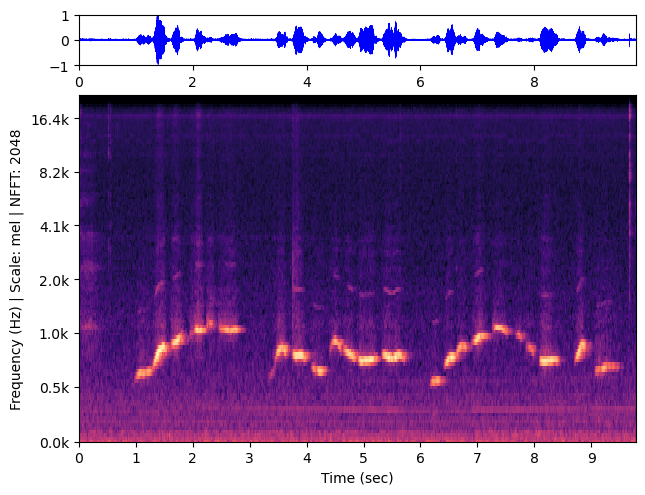

In [22]:
sp = {'n_fft': 2**11, 'chop_length': 128, 'n_mels': 128}
fig = wav2mp4("wantugone.wav", scale = "linear", save=save, spec_params=sp)

drawing plot
saving video
write frame 249/250
adding sound to video
saved to test/wantugone_wide.mel.02048.mp4


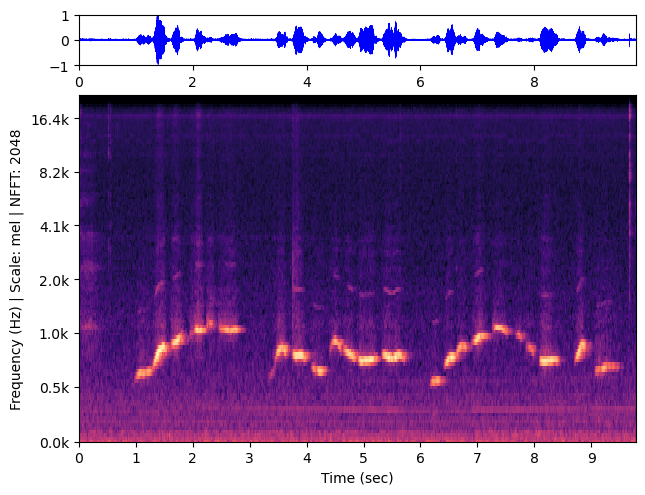

In [22]:
sp = {'n_fft': 2**11, 'chop_length': 128, 'n_mels': 128}
fig = wav2mp4("wantugone.wav", scale = "mel", save=save, spec_params=sp)

drawing plot


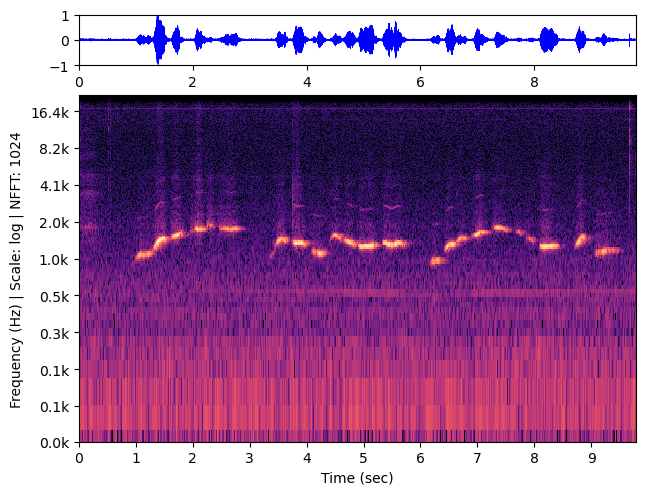

In [239]:
fig = wav2mp4("wantugone.wav", scale = "log", save=save)

## Videos for presentation 

spiritus.wav  
fiona.wav  
sacrifice.wav  
trumpet.wav  
dolphin.wav  
environment.wav  

music_gt_2.wav  
music_audiosr_2.wav  
music_up_2.wav  
speech_gt_1.wav  
speech_up_1.wav  
speech_audiosr_1.wav  
event_gt_3.wav  
event_up_3.wav  

lpf.wav  

In [7]:
save = 0

drawing plot
saving video
adding sound to video
saved to Media/spiritus.linear.01024.mp4


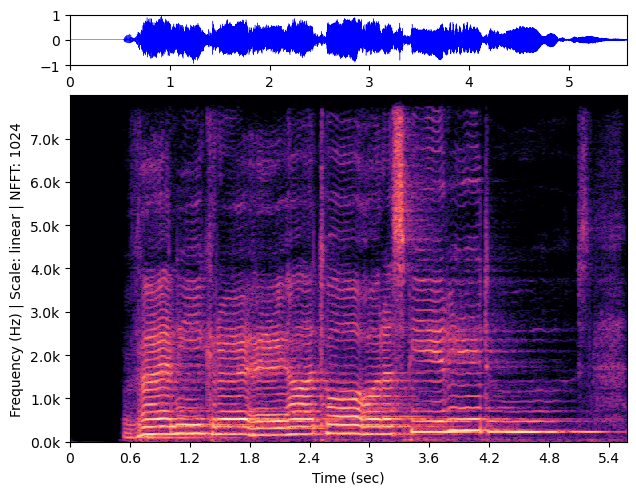

In [327]:
scale = "linear"
sp = {'n_fft': 1024, 'hop_length': 128, 'n_mels': 128}
fig = wav2mp4("Media/spiritus.wav", scale = scale, save=save, spec_params=sp)

### fiona

drawing plot
saving video
write frame 400/400
adding sound to video
saved to Media/fiona.linear.02048.mp4


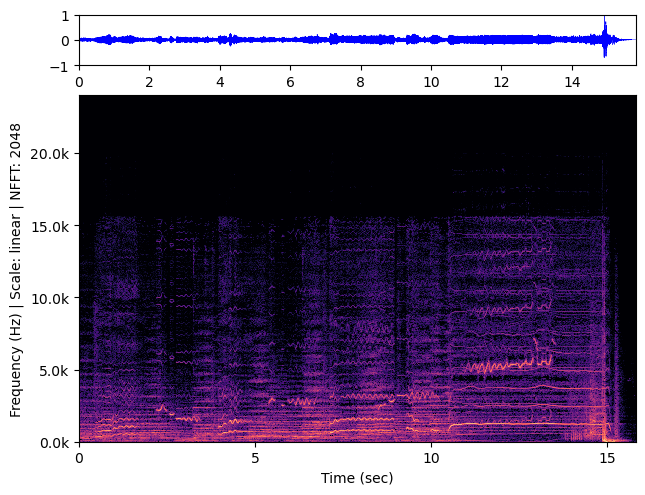

In [25]:
sp = {'n_fft': 2048, 'hop_length': 128, 'n_mels': 256}
fig = wav2mp4("Media/fiona.wav", scale = scale, save=save, spec_params=sp)

### sacrifice

drawing plot
saving video
write frame 150/150
adding sound to video
saved to Media/sacrifice.mel.01024.mp4


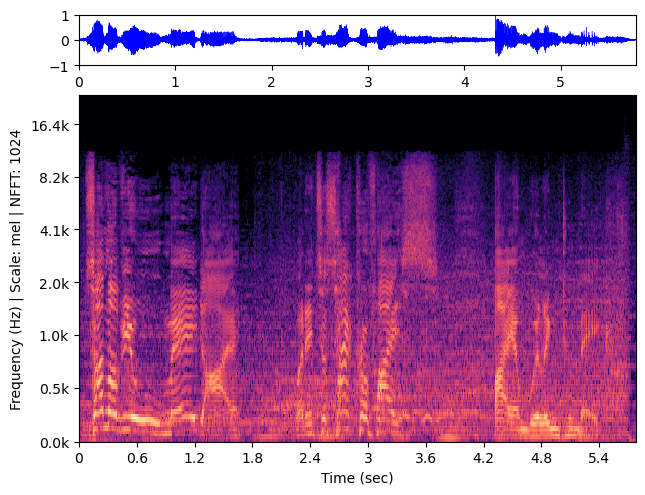

In [26]:
scale = "mel"
sp = {'n_fft': 1024, 'hop_length': 128, 'n_mels': 256}
fig = wav2mp4("Media/sacrifice.wav", scale = scale, save=save, spec_params=sp)

### trumpet

drawing plot
saving video
write frame 225/225
adding sound to video
saved to Media/trumpet.linear.01024.mp4


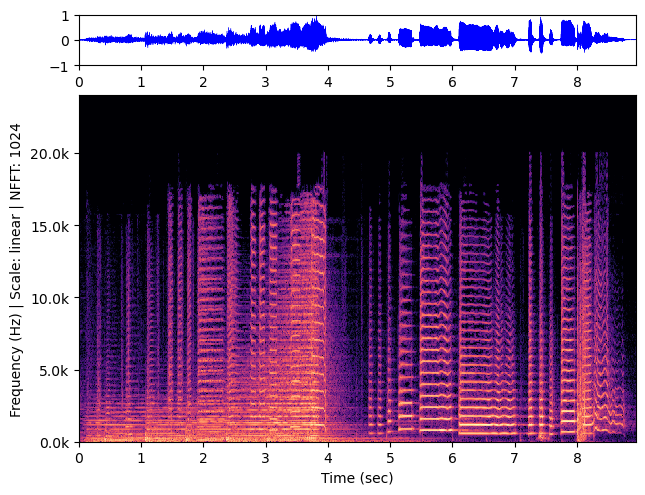

In [27]:
scale = "linear" 
sp = {'n_fft': 1024, 'hop_length': 128, 'n_mels': 256}
fig = wav2mp4("Media/trumpet.wav", scale = scale, save=save, spec_params=sp)

### dolphin

drawing plot
saving video
write frame 75/75
adding sound to video
saved to Media/dolphin.linear.01024.mp4


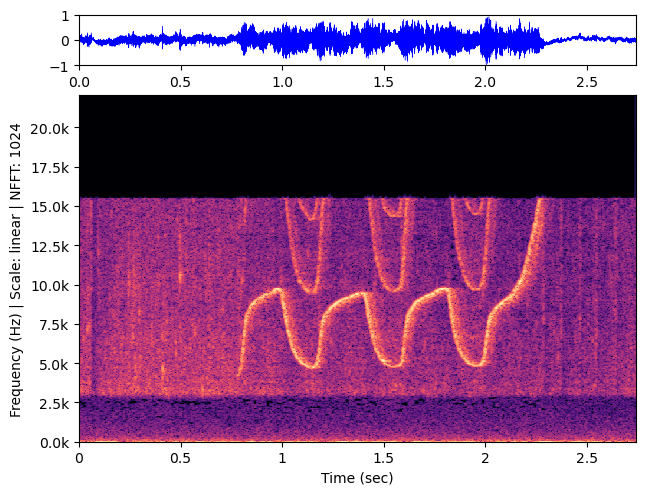

In [28]:
scale = "linear"
sp = {'n_fft': 1024, 'hop_length': 128, 'n_mels': 256}
fig = wav2mp4("Media/dolphin.wav", scale = scale, save=save, spec_params=sp)

### environment

/tmp/ipykernel_1646474/1738648081.py:21: RuntimeWarning: overflow encountered in scalar absolute
  audio = audio/max(abs(audio.min()),audio.max())


drawing plot
saving video
write frame 850/850
adding sound to video
saved to Media/environment.mel.02048.mp4


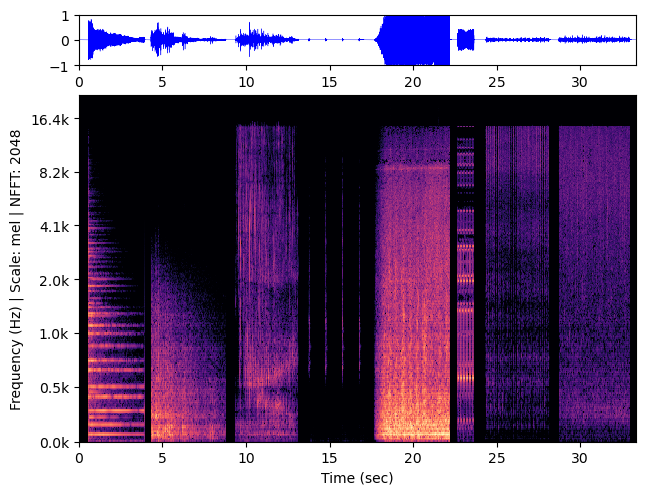

In [29]:
scale = "mel"
sp = {'n_fft': 2048, 'hop_length': 128, 'n_mels': 512}
fig = wav2mp4("Media/environment.wav", scale = scale, save=save, spec_params=sp)

### audiosr samples

drawing plot
saving video
write frame 150/150
adding sound to video
saved to Media/event_audiosr_3.mel.02048.mp4


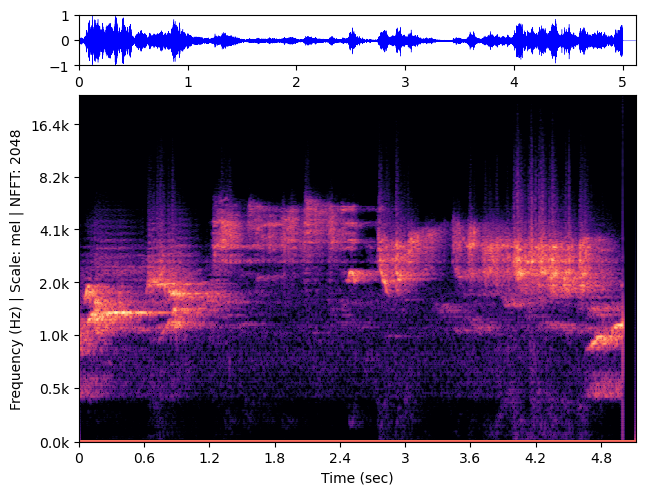

In [32]:
audiosr = """music_gt_2.wav
music_audiosr_2.wav
music_up_2.wav
speech_gt_1.wav
speech_up_1.wav
speech_audiosr_1.wav
event_gt_3.wav
event_up_3.wav
event_audiosr_3.wav"""

scale = "mel" #"linear" #

i=11
for f in audiosr.split("\n"):
    
    sp = {'n_fft': 2**i, 'hop_length': 128, 'n_mels': 2**(i-2)}
    fig = wav2mp4("Media/" + f, scale = scale, save=save, spec_params=sp)


### low pass filtered

/tmp/ipykernel_1646474/1738648081.py:21: RuntimeWarning: overflow encountered in scalar absolute
  audio = audio/max(abs(audio.min()),audio.max())


drawing plot
saving video
write frame 350/350
adding sound to video
saved to Media/lpf.mel.02048.mp4


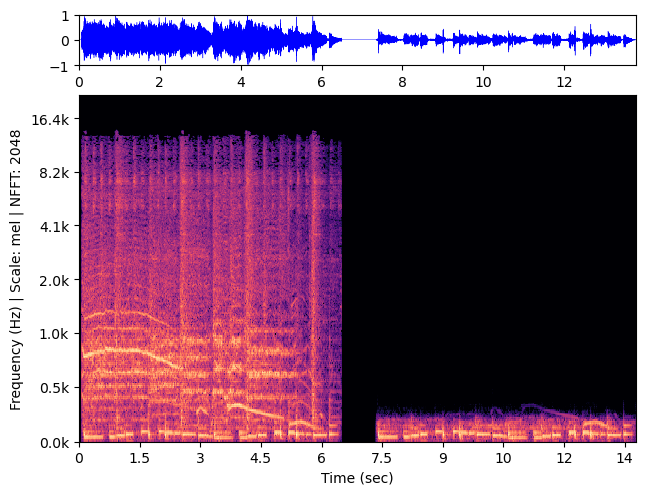

In [31]:
scale = "mel"
i=11
save = 0
sp = {'n_fft': 2048, 'hop_length': 128, 'n_mels': 2**(i-2)}
print(sp)
fig = wav2mp4("Media/lpf.wav", scale = scale, save=save, spec_params=sp)

## GIFs for presentation


### layers - variable NFFT
```
layers.*.mel.gif
```
Shows how resulting image varies with nfft 

In [2]:
filename = "Media/layers" # .wav
scale = "mel" #"linear" #
save = 0

for i in range(8,14):
    sp = {'n_fft': 2**i, 'hop_length': 128, 'n_mels': 2**(i-2)}
    fig = wav2mp4(filename + ".wav", scale = scale, save=save, spec_params=sp)

make_gif(f"{filename}.{scale}.*.png")

### layers - variable scale

```
layers.2048.*.gif
```
Shows how freq varies with scale

drawing plot
drawing plot
Media/layers.*.02048.png
['Media/layers.linear.02048.png', 'Media/layers.mel.02048.png']
2


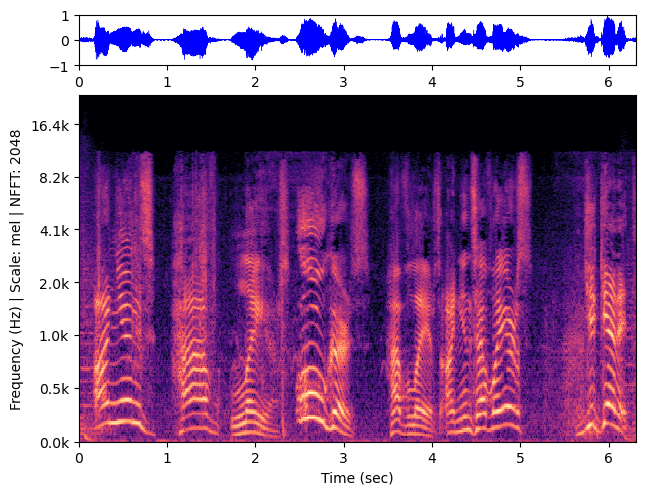

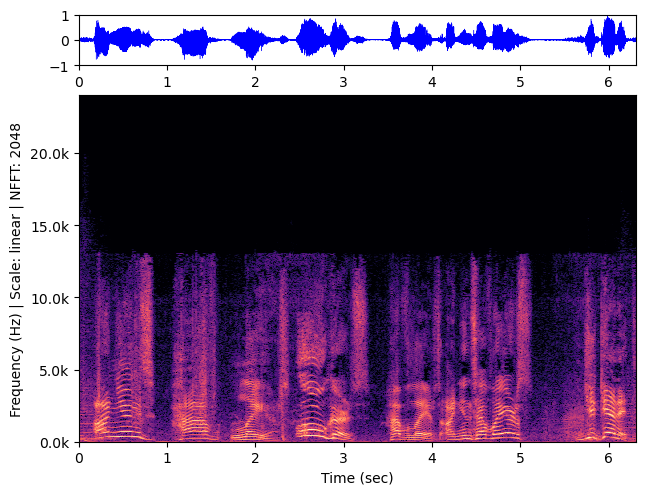

In [279]:
filename = "Media/layers" # .wav
scale = "mel" #"linear" #
i=11
save = 0

for j in ["mel","linear"]:
    
    sp = {'n_fft': 2**i, 'hop_length': 128, 'n_mels': 2**(i-2)}
    fig = wav2mp4(filename + ".wav", scale = j, save=save, spec_params=sp)

make_gif(f"{filename}.*.0{2**i}.png")